In [1]:
import numpy as np
import scipy as sp
import pylab as pl
pl.rcParams['figure.figsize'] = 4,4

In [2]:
from gmm_base import *

In [3]:
lamb = 0.5
xmax = 4/lamb
sample_size = int(1e4)
num_clusters = 3
epochs = 1000

In [4]:
x = np.random.RandomState(0).exponential(1./lamb, sample_size)

In [5]:
def Gaussian_pdf(ex):
    return np.exp(- 0.5*(ex-x.mean())**2/x.std()**2
                  - 0.5*np.log(2*np.pi*x.std()**2))

(-0.4191023651728891, 8.0)

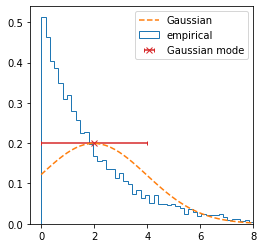

In [6]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label='empirical');

pl.plot(ex, Gaussian_pdf(ex), '--', label='Gaussian')
pl.errorbar([x.mean()], Gaussian_pdf([x.mean()]), None, [x.std()],
            'x', color='C3', capsize=2, label='Gaussian mode')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)

# EM

In [7]:
model = GMMModel(x[:,None], num_clusters=num_clusters)
trainer = GMMTrainer(model)

for t, epoch in elapsed(range(100)):
    trainer(x[:,None])
    if np.allclose(np.log2(epoch+1), np.round(np.log2(epoch+1))) or epoch+1==100:
        loglik = model(mx.nd.array(x[:,None]))[0].mean().asscalar()
        print(f'{epoch+1} loglik={loglik:.3f} elapsed={t:.1f}s')

1 loglik=-2.111 elapsed=0.0s
2 loglik=-2.089 elapsed=0.0s
4 loglik=-1.952 elapsed=0.0s
8 loglik=-1.887 elapsed=0.1s
16 loglik=-1.799 elapsed=0.1s
32 loglik=-1.778 elapsed=0.3s
64 loglik=-1.775 elapsed=0.8s
100 loglik=-1.774 elapsed=1.1s


In [8]:
hat_lambda = infer_lambda(model, xmin=0, xmax=xmax)
print(f'inferred lamb={hat_lambda:.3f}')

inferred lamb=0.425


In [9]:
def mixture_pdf(ex):
    log_marg = model(mx.nd.array(ex, dtype='float32'))[0]
    return log_marg.exp().asnumpy()

In [10]:
log_prior_ = model.log_prior_.data().asnumpy()
mu_ = model.mu_.data().asnumpy()
kR_ = model.kR_.data().asnumpy()
cov_ = np.linalg.inv(kR_.swapaxes(1,2) @ kR_)
s2_ = np.array([np.diag(c) for c in cov_])

(-0.4, 8.0)

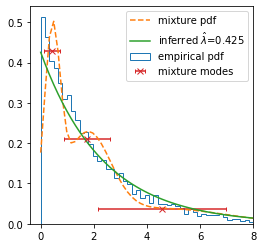

In [11]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label='empirical pdf')

pl.plot(ex, mixture_pdf(ex[:,None]), '--', label='mixture pdf')

pl.plot(ex, hat_lambda*np.exp(-hat_lambda*ex),
        label=f'inferred $\hat\lambda$={hat_lambda:.3f}')

pl.errorbar(mu_.squeeze(-1),
            np.exp(log_prior_) / (2*np.pi*s2_.squeeze(-1))**0.5,
            None, s2_.squeeze(-1)**0.5,
            'x', capsize=2, label='mixture modes')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)